In [89]:
from pystac_client import Client
from radiant_mlhub import Collection, Dataset
import radiant_mlhub as re

from common.sagemaker_env import RADIANT_EARTH_API_KEY


re_landcover_dir = "./data/radiantEarth/landcover"

client = Client.open("https://api.radiant.earth/mlhub/v1", parameters={"key": RADIANT_EARTH_API_KEY})

collections = [
    # 'ref_landcovernet_as_v1_labels',
    #'ref_landcovernet_na_v1_labels',
    #'ref_landcovernet_au_v1_labels',
    # 'ref_landcovernet_af_v1_labels',
    # 'ref_landcovernet_eu_v1_labels',
    # 'ref_landcovernet_as_v1_source_sentinel_2',
    # 'ref_landcovernet_na_v1_source_sentinel_2', rerun this to complete
    'ref_landcovernet_au_v1_source_sentinel_2',
    # 'ref_landcovernet_af_v1_source_sentinel_2'
    # 'ref_landcovernet_eu_v1_source_sentinel_2',
]

cloud_model_path = "./cloud_detection_model_resnet18_dice_20230327.pth"

re_landcover_state_path = f'{re_landcover_dir}/state'


In [ ]:
%reload_ext autoreload
%autoreload 2

from functools import partial
import itertools
import logging
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
from osgeo import gdal, gdalconst
from pystac import ItemCollection
from pystac_client import Client
import rasterio
import requests
from scipy.ndimage import maximum_filter
import shelve
import shutil
import torch

from common.constants import NODATA_BYTE, NODATA_FLOAT32
from common.sagemaker_env import RADIANT_EARTH_API_KEY
from common.utilities.download import get_scene_metadata
from common.utilities.imagery import normalize_original_s2_array, write_array_to_tif
from common.utilities.masking import _buffer_mask
import common.utilities.visualization as viz



def get_cloud_mask(stack_data):
    
    image = stack_data
    image[image==NODATA_FLOAT32] = -1
    
    image = np.expand_dims(image, 0)
    image = torch.tensor(image)
        
    model = torch.load(cloud_model_path)
    prediction = model.predict(image)

    probabilities = torch.sigmoid(prediction).cpu().numpy()
    probabilities = probabilities[0, 0, :, :]
    binary_prediction = (probabilities >= 0.50).astype(bool)    
    
    return binary_prediction
    
    
def process_item(item, state):

    role = state['role']
    items_dir = state['items_dir']
            
    chip_id = item.id.split(collection_id)[1][1:]
    if role == "source":
        chip_id = chip_id[:-9]

    chip_path = f'{items_dir}/{chip_id}.tif'
    chip_pass_path = f'{items_dir}/pass/{item.id}'
    chip_90deg_path = f'{items_dir}/{chip_id}_90deg.tif'

    if os.path.exists(chip_path) or os.path.exists(chip_pass_path):
        return

    # setup loop to handle network errors
    while True:
        try:
            if role == "labels":
                labels_href = item.assets['labels'].href

                # not using requests to download because labels are UInt16 and pooly formated
                with rasterio.open(labels_href) as labels_src:
                    labels_data = labels_src.read(1).astype(np.uint8) # band 2 is consensus score
                    write_array_to_tif(labels_data, chip_path, None, dtype=np.uint8, nodata=NODATA_BYTE, transform=labels_src.transform)

            elif role == "source":                    

                # get SCL and make sure less than threshold
                with rasterio.open(item.assets['SCL'].href) as scl_src:
                    scl_data = scl_src.read(1)

                cloud_mask = np.isin(scl_data, [0, 1, 2, 3, 7, 8, 9, 10, 11])
                cloud_ratio = np.mean(cloud_mask)
                if cloud_ratio > 0.20:
                    with open(chip_pass_path, "w") as f:
                        pass
                    break

                stack_data = []
                source_bbox = None
                source_epsg = None
                for band in item.assets:
                    if band in ["B02", "B03", "B04", "B08"]:                  
                        with rasterio.open(item.assets[band].href) as band_src:
                            band_data = band_src.read(1)
                            stack_data.append(band_data)
                            source_bbox = list(band_src.bounds)
                            source_epsg = band_src.crs.to_epsg()

                stack_data = np.array(stack_data)
                stack_data = normalize_original_s2_array(stack_data)
                
                nn_cloud_mask = get_cloud_mask(stack_data)
                nn_cloud_mask = _buffer_mask(nn_cloud_mask, radius=12)

                stack_data[:, nn_cloud_mask] = NODATA_FLOAT32
                stack_data[:, cloud_mask] = NODATA_FLOAT32

                stack_data = stack_data.transpose((1, 2, 0))
                write_array_to_tif(stack_data, chip_path, source_bbox, dtype=np.float32, epsg=source_epsg, nodata=NODATA_FLOAT32)    

            break

        except Exception as e:
            print('error:', e)
            raise    


for collection_id in collections:
    
    if "_v1_labels" in collection_id:
        role = "labels"
    elif "_v1_source_sentinel_2" in collection_id:
        role = "source"
    else:
        raise Exception("unknown collection_id")
    
    items_dir = f'{re_landcover_dir}/{role}'
    os.makedirs(f'{items_dir}', exist_ok=True)
    if role == "source":
        os.makedirs(f'{items_dir}/pass', exist_ok=True)

    print(collection_id, items_dir)

    collection = client.get_collection(collection_id)
    results = collection.get_items()

    pool_state = dict(items_dir=items_dir, role=role)
    
    while True:
        results_slice = list(itertools.islice(results, 0, 1024))
        if not results_slice:
            break
        
        print(f'\tcreating pool of {len(results_slice)} items with {multiprocessing.cpu_count()} processes')
        partial_process_item = partial(process_item, state=pool_state)
        with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
            pool.map(partial_process_item, results_slice)

print('done')

ref_landcovernet_au_v1_source_sentinel_2 ./data/radiantEarth/landcover/source
	creating pool of 1024 items with 16 processes
	creating pool of 1024 items with 16 processes
	creating pool of 1024 items with 16 processes
	creating pool of 1024 items with 16 processes
	creating pool of 1024 items with 16 processes
	creating pool of 1024 items with 16 processes
	creating pool of 1024 items with 16 processes
	creating pool of 1024 items with 16 processes


## Data augmentation

### asdf

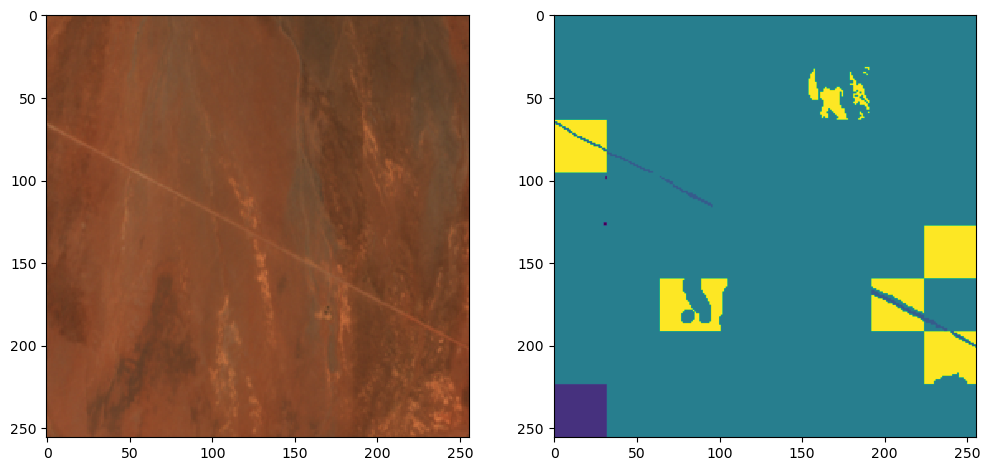

In [60]:
import matplotlib.pyplot as plt
import rasterio
from common.utilities.visualization import plot_bands


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

file_name = "34JBL_01.tif"

with rasterio.open(f"./data/radiantEarth/landcover/source/{file_name}") as src:
    plot_bands(src.read(masked=True), ax=ax1, bands=[2, 1, 0], transpose=True)
        
with rasterio.open(f"./data/radiantEarth/landcover/labels/{file_name}") as src:
    ax2.imshow(src.read(1), vmin=0, vmax=7)


In [53]:
%%bash

gdalinfo -stats ./data/radiantEarth/landcover/source/38NPP_29_temp/B08.tif

Driver: GTiff/GeoTIFF
Files: ./data/radiantEarth/landcover/source/38NPP_29_temp/B08.tif
Size is 256, 256
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 38N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 38N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",45,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
 

In [42]:

x = "38NPP_29_20181231"
print(x[:-9])


38NPP_29


## Clouds

In [2]:
re_cloud_dir = "./data/radiantEarth/clouds/"
dataset = Dataset.fetch('ref_cloud_cover_detection_challenge_v1')
#dataset.download(output_dir=re_cloud_dir)

NameError: name 'Dataset' is not defined

In [7]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import os
from osgeo import gdal
from pystac import ItemCollection
from pystac_client import Client
import rasterio
import requests
import shutil


from common.constants import NODATA_FLOAT32
from common.sagemaker_env import RADIANT_EARTH_API_KEY
import common.utilities.imagery as imagery
import common.utilities.visualization as viz



# Open a catalog
client = Client.open("https://api.radiant.earth/mlhub/v1", parameters={"key": RADIANT_EARTH_API_KEY})

collections = [
        'ref_cloud_cover_detection_challenge_v1_train_source',
        'ref_cloud_cover_detection_challenge_v1_train_labels',
        'ref_cloud_cover_detection_challenge_v1_test_source',
        'ref_cloud_cover_detection_challenge_v1_test_labels',
]


re_cloud_dir = "./data/radiantEarth/clouds"



import timeit
import matplotlib.pyplot as plt

for collection_id in collections:

    role = collection_id.split('_')[-1]
    stage = collection_id.split('_')[-2]
    items_dir = f'{re_cloud_dir}/{role}'
    os.makedirs(items_dir, exist_ok=True)

    print(collection_id, items_dir)
    
    collection = client.get_collection(collection_id)
    results = collection.get_items()
        
    for i, item in enumerate(results):

        chip_id = item.id.split('_')[-1] # chip_id
        chip_path = f'{items_dir}/{chip_id}.tif'
        chip_90deg_path = f'{items_dir}/{chip_id}_90deg.tif'

        if i % 50 == 0:
            print(f'\t{i} chips done')
            
        if i == 150:
            break
            
        if os.path.exists(chip_path):
            
            # rotate images 90 degrees
            if not os.path.exists(chip_90deg_path):
                with rasterio.open(chip_path) as src:
                    bbox = list(src.bounds)
                    if role == "source":
                        data = src.read()
                        data_90deg = np.rot90(data, axes=(1, 2)).transpose((1, 2, 0))
                        imagery.write_array_to_tif(data_90deg, chip_90deg_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
                    elif role == "labels":
                        data = src.read(1)
                        data_90deg = np.rot90(data, axes=(0, 1))
                        imagery.write_array_to_tif(data_90deg, chip_90deg_path, bbox, dtype=np.uint8, nodata=255)
                        
            continue
            
        while True:
            try:
                if role == "labels":
                    asset_href = item.assets['raster_labels'].href
                    response = requests.get(asset_href)
                    with open(chip_path, 'wb') as f:
                        f.write(response.content)

                else:
                    temp_dir = f'{items_dir}/{chip_id}_temp'
                    os.makedirs(temp_dir, exist_ok=True)
                    
                    band_paths = []
                    for band in item.assets:
                        band_path = f'{temp_dir}/{band}.tif'                
                        band_paths.append(band_path)
                        band_href = item.assets[band].href
                        response = requests.get(band_href)
                        with open(band_path, 'wb') as f:
                            f.write(response.content)
                                                        
                    stack_data = []
                    bbox, epsg = None, 4326
                    for path in band_paths:
                        with rasterio.open(path) as src:
                            stack_data.append(src.read(1))
                            bbox = list(src.bounds)
                            epsg = src.crs.to_epsg()                       
                                                        
                    stack_data = np.array(stack_data).astype(np.float32)
                    stack_data = imagery.normalize_original_s2_array(stack_data)
                    stack_data = stack_data.transpose((1, 2, 0))
                    imagery.write_array_to_tif(stack_data, chip_path, bbox, dtype=np.float32, epsg=epsg, nodata=NODATA_FLOAT32) 
                                
                    shutil.rmtree(temp_dir)
                    
                break
                    
            except Exception as e:
                print('error:', e)
                raise
                
print('done')

ref_cloud_cover_detection_challenge_v1_train_source ./data/radiantEarth/clouds/source
	0 chips done
	50 chips done
	100 chips done
	150 chips done
ref_cloud_cover_detection_challenge_v1_train_labels ./data/radiantEarth/clouds/labels
	0 chips done
	50 chips done
	100 chips done
	150 chips done
ref_cloud_cover_detection_challenge_v1_test_source ./data/radiantEarth/clouds/source
	0 chips done
	50 chips done
	100 chips done
	150 chips done
ref_cloud_cover_detection_challenge_v1_test_labels ./data/radiantEarth/clouds/labels
	0 chips done
	50 chips done
	100 chips done
	150 chips done
done


1600
0.00976801 0.21611721813678741 1.0
0.04053724 0.1308913379907608 1.0
0.004884005 0.7316239476203918 1.0


RuntimeError: No active exception to reraise

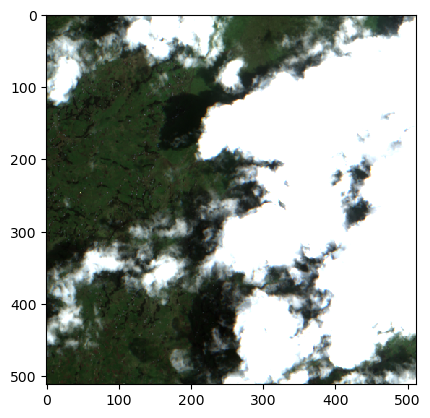

In [10]:
import glob
import rasterio

from common.utilities.visualization import plot_bands

files = glob.glob('./data/radiantEarth/clouds/source/*.tif')

print(len(files))
for fp in files[:50]:
    with rasterio.open(fp) as src:
        data = src.read(masked=True)
        print(np.min(data), np.ma.median(data), np.max(data))
        
        if np.ma.median(data) > 0.4:
            plot_bands(data, bands=[2, 1, 0], transpose=True)
            raise



In [11]:
import matplotlib.pyplot as plt
import rasterio

from common.utilities.visualization import plot_bands

chip_id = "cxoz_90deg"

with rasterio.open(f'./data/radiantEarth/clouds/source/{chip_id}.tif') as src:
    source = src.read()

with rasterio.open(f'./data/radiantEarth/clouds/labels/{chip_id}.tif') as src:
    labels = src.read(1)    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
plot_bands(source, bands=[2, 1, 0], ax=ax1, transpose=True)
ax2.imshow(labels)
plt.show()


RasterioIOError: ./data/radiantEarth/clouds/source/cxoz_90deg.tif: No such file or directory

In [11]:
%%bash

gdalinfo ./data/radiantEarth/clouds/train/labels/xeak.tif

Driver: GTiff/GeoTIFF
Files: ./data/radiantEarth/clouds/train/source/xeak.tif
Size is 512, 512
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 21N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 21N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-57,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
          